In [2]:
import sys
sys.path.append('./utils')  # make sure Python knows where to look

import os
os.environ['DYLD_INSERT_LIBRARIES'] = ''
if 'MallocStackLogging' in os.environ:
    del os.environ['MallocStackLogging']

import numpy as np
# Fix deprecated np.int for NumPy 1.20+ (mlens library still uses deprecated aliases)
if not hasattr(np, 'int'):
    np.int = np.int64
    np.float = np.float64
    np.complex = np.complex128
    np.object = np.object_
    np.str = np.str_
    np.long = np.int64
    np.unicode = np.str_

# Display full output in Jupyter
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import datetime
import pandas as pd
from sklearn.base import clone
from numpy import hstack, vstack
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, average_precision_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import ml_training_functions as utils_training
import file_handler_functions as utils_file


In [3]:
# Load data from the 2018-07-25 to the 2018-08-14
DIR_INPUT='./data/simulated-data-transformed/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df = utils_file.read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

START_DATE = "2018-07-25"
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

# Number of folds for the prequential validation
n_folds = 4

start_date_training = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

Load  files
CPU times: user 111 ms, sys: 185 ms, total: 296 ms
Wall time: 471 ms
622892 transactions loaded, containing 5515 fraudulent transactions


In [4]:
output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

# Split dataset for Cross validation
prequential_split_indices=utils_training.prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)


In [5]:
def get_base_models_tuning():
    return {
        'XGBClassifier': XGBClassifier(
            learning_rate = 0.3,
            max_depth = 3,
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            scale_pos_weight = 10
        ),
        'LGBMClassifier': LGBMClassifier(
            learning_rate = 0.1,
            max_depth = 3,
            n_estimators = 100,
            n_jobs=-1,
            random_state=0,
            scale_pos_weight=1, 
            verbosity=-1
        ),
        'CatBoostClassifier': CatBoostClassifier(
            depth = 4,
            iterations = 500,
            learning_rate = 0.05,
            random_state = 0,
            scale_pos_weight = 5,
            # prefer class_weights if heavy imbalance; we'll rely on default + tuned params
            # class_weights can be added if desired, e.g. class_weights=[1, 99]
            verbose = 0
        ),
        'HistGradientBoostingClassifier': HistGradientBoostingClassifier(
            max_iter = 100,
            learning_rate = 0.05,
            max_depth = 5,
            random_state = 0,
            class_weight = 'balanced'
        ),
        'BalancedRandomForestClassifier': BalancedRandomForestClassifier(
            max_depth = 20,
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampling_strategy = 0.05
        ),
        'BalancedBaggingClassifier': BalancedBaggingClassifier(
            bootstrap = True,
            estimator = DecisionTreeClassifier(max_depth=20, random_state=0),
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampler = RandomUnderSampler(),
            sampling_strategy = 0.1
        ),
        'LogisticRegression': LogisticRegression(
            C=0.1,
            random_state=0,
            class_weight='balanced'
        )
    }
    
def get_base_models():
    return {
        'XGBClassifier': XGBClassifier(
            learning_rate = 0.1,
            max_depth = 3,
            n_estimators = 50,
            n_jobs = -1,
            random_state = 0,
            scale_pos_weight = 10
        ),
        'LGBMClassifier': LGBMClassifier(
            learning_rate = 0.1,
            max_depth = 3,
            n_estimators = 50,
            n_jobs=-1,
            random_state=0,
            scale_pos_weight=1
        ),
        'CatBoostClassifier': CatBoostClassifier(
            depth = 4,
            iterations = 500,
            learning_rate = 0.05,
            random_state = 0,
            class_weights=[1, 99],
            verbose = 0
        ),
        'HistGradientBoostingClassifier': HistGradientBoostingClassifier(
            max_iter = 100,
            learning_rate = 0.05,
            max_depth = 5,
            random_state = 0,
            class_weight = 'balanced'
        ),
        'BalancedRandomForestClassifier': BalancedRandomForestClassifier(
            max_depth = 50,
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampling_strategy = 0.1
        ),
        'BalancedBaggingClassifier': BalancedBaggingClassifier(
            bootstrap = True,
            estimator = DecisionTreeClassifier(max_depth=20, random_state=0),
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampler = RandomUnderSampler(),
            sampling_strategy = 0.1
        ),
        'LogisticRegression': LogisticRegression(
            class_weight='balanced',
            C=0.1,
            random_state=0,
            solver='liblinear'
        ),
    }

# for this function, the transactions_df_scorer must contain CUSTOMER_ID and TX_TIME_DAYS for the full df; X_index are the indices for the current test fold.
def card_precision_top_k_wrapper(probs, X_index, transactions_df_scorer, k=100):
    preds_df = transactions_df_scorer.loc[X_index].copy()
    preds_df['predictions'] = probs
    nb, per_day_list, mean_cp = utils_training.card_precision_top_k(preds_df, k)
    return mean_cp

# out-of-fold builder (prequential-friendly)
def get_out_of_fold_predictions_no_sampling(transactions_df, prequential_split_indices, base_models_dict,
                                           input_features, output_feature, transactions_df_scorer=None):
    meta_rows = []
    meta_labels = []
    meta_indices = []
    model_names = list(base_models_dict.keys())

    # iterate prequential folds
    for fold_i, (train_ix, test_ix) in enumerate(prequential_split_indices):
        # get train/test slices (no sampling)
        train_df = transactions_df.iloc[train_ix]
        test_df = transactions_df.iloc[test_ix]
        X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

        # scale: fit scaler on training fold only, transform train/test
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # collect base model predictions
        fold_preds = []

        for name in model_names:
            # initailized a new model instance on different fold
            model = clone(base_models_dict[name]) 
            model.fit(X_train_scaled, y_train)
            probs = utils_training.get_predict_proba(model, X_test_scaled)

            fold_preds.append(probs.reshape(-1, 1))

        # stack column-wise to shape (n_test_rows, n_models)
        fold_meta_X = np.hstack(fold_preds)

        meta_rows.append(fold_meta_X)
        meta_labels.append(y_test)
        
        # keep original indices for evaluation (card precision)
        meta_indices.append(test_df.index)

    # vertically stack folds
    meta_X = np.vstack(meta_rows)
    meta_y = np.concatenate(meta_labels)
    meta_index = np.concatenate([np.array(idx) for idx in meta_indices])

    return meta_X, meta_y, meta_index, model_names

# Fit base models on full training data (no sampling)
def fit_base_models_full(X_train_df, y_train_series, base_models_dict):
    fitted_models = {}
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df.values)   # we will also store this scaler for test transforms if needed
    for name, model in base_models_dict.items():
        m = clone(model)
        m.fit(X_train_scaled, y_train_series.values)
        fitted_models[name] = m
    return fitted_models, scaler

# Fit meta model (LogisticRegression) on meta features
def fit_meta_model(base_models, meta_X, meta_y):
    meta_model = base_models['LogisticRegression']
    meta_model.fit(meta_X, meta_y)
    return meta_model

# Super-learner prediction helper for producing probability predictions on test set
def super_learner_predict_proba(models_fitted_dict, meta_model, X_test_df, scaler=None):
    # transform X_test appropriately (if scaler provided)
    if scaler is not None:
        X_test_scaled = scaler.transform(X_test_df.values)
    else:
        X_test_scaled = X_test_df.values

    probs_list = []
    for _, model in models_fitted_dict.items():
        probs = utils_training.get_predict_proba(model, X_test_scaled)
        probs_list.append(probs)
        
    meta_X_test = np.hstack(probs_list)
    
    # meta_model should support predict_proba
    if hasattr(meta_model, "predict_proba"):
        return meta_model.predict_proba(meta_X_test)[:, 1]
    else:
        # fallback
        return meta_model.predict(meta_X_test)

def get_train_test_features(train_df, test_df, input_features, output_feature):
    return (train_df[input_features].values, 
            train_df[output_feature].values,
            test_df[input_features].values,
            test_df[output_feature].values)

def get_performance_metrics(df, y, probs, transactions_df_scorer):
    auc = roc_auc_score(y, probs)
    ap  = average_precision_score(y, probs)
    cp = None
    if transactions_df_scorer is not None:
        cp = card_precision_top_k_wrapper(probs, df.index, transactions_df_scorer, k=100)
        
    return auc, ap, cp
    
def evaluate_base_models_per_fold(base_models_dict, train_df, test_df,
                                  input_features, output_feature,
                                  transactions_df_scorer=None):
    X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

    # scale using train only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    fold_results = {}

    for name, model in base_models_dict.items():
        m = clone(model)
        m.fit(X_train_scaled, y_train)

        # Predicting train set and test set
        train_probs = utils_training.get_predict_proba(m, X_train_scaled)
        test_probs = utils_training.get_predict_proba(m, X_test_scaled)
        
        train_auc, train_ap, train_cp = get_performance_metrics(train_df, y_train, train_probs, transactions_df_scorer)
        test_auc, test_ap, test_cp = get_performance_metrics(test_df, y_test, test_probs, transactions_df_scorer)

        train_performance_detail = {'n_train': len(train_df), 'auc': train_auc, 'ap': train_ap, 'cp100': train_cp}
        test_performance_detail = {'n_train': len(test_df), 'auc': test_auc, 'ap': test_ap, 'cp100': test_cp}
        fold_results[name] = {'train': train_performance_detail, 'test': test_performance_detail}

    return fold_results


def evaluate_super_learner_per_fold(fitted_base_models, meta_model,
                                    train_df, test_df,
                                    input_features, output_feature,
                                    scaler, transactions_df_scorer=None):
    X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

    # scale test set with global scaler
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # build meta features for train
    train_meta = []
    for m in fitted_base_models.values():
        train_probs = utils_training.get_predict_proba(m, X_train_scaled)
        train_meta.append(train_probs.reshape(-1, 1))
    X_train_meta = np.hstack(train_meta)

    # build meta features for test
    test_meta = []
    for m in fitted_base_models.values():
        test_probs = utils_training.get_predict_proba(m, X_test_scaled)
        test_meta.append(test_probs.reshape(-1, 1))
    X_test_meta = np.hstack(test_meta)

    # predict using meta model
    train_probs = meta_model.predict_proba(X_train_meta)[:, 1]
    test_probs  = meta_model.predict_proba(X_test_meta)[:, 1]
    
    train_auc, train_ap, train_cp = get_performance_metrics(train_df, y_train, train_probs, transactions_df_scorer)
    test_auc, test_ap, test_cp = get_performance_metrics(test_df, y_test, test_probs, transactions_df_scorer)

    train_performance_detail = {'n_train': len(train_df), 'auc': train_auc, 'ap': train_ap, 'cp100': train_cp}
    test_performance_detail = {'n_train': len(test_df), 'auc': test_auc, 'ap': test_ap, 'cp100': test_cp}
    return {'train': train_performance_detail, 'test': test_performance_detail}

def summarize_performance_across_folds(per_fold_results):
    train_auc = []
    train_ap = []
    train_cp = []
    test_auc = []
    test_ap = []
    test_cp = []

    for item in per_fold_results:
        r_train = item['results']['train']
        r_test  = item['results']['test']

        train_auc.append(r_train['auc'])
        train_ap.append(r_train['ap'])
        train_cp.append(r_train['cp100'])

        test_auc.append(r_test['auc'])
        test_ap.append(r_test['ap'])
        test_cp.append(r_test['cp100'])

    return {
        'train_auc_mean': f'{np.mean(train_auc):.4f}',
        'train_ap_mean': f'{np.mean(train_ap):.4f}',
        'train_cp100_mean': f'{np.mean(train_cp):.4f}',
        'test_auc_mean': f'{np.mean(test_auc):.4f}',
        'test_ap_mean': f'{np.mean(test_ap):.4f}',
        'test_cp100_mean': f'{np.mean(test_cp):.4f}',
    }

# Full pipeline runner (ties everything together)
def run_super_learner(base_models, transactions_df, prequential_split_indices,
                              input_features, output_feature,
                              transactions_df_scorer=None, verbose=True):

    # -------------------- OOF meta features --------------------
    meta_X, meta_y, meta_index, model_names = get_out_of_fold_predictions_no_sampling(
        transactions_df, prequential_split_indices, base_models,
        input_features, output_feature, transactions_df_scorer
    )
    meta_model = fit_meta_model(base_models, meta_X, meta_y)

    # -------------------- fit base models on first window --------------------
    first_train_ix, _ = prequential_split_indices[0]
    train_df_full = transactions_df.iloc[first_train_ix]
    X_train_full = train_df_full[input_features]
    y_train_full = train_df_full[output_feature]

    fitted_base_models, global_scaler = fit_base_models_full(
        X_train_full, y_train_full, base_models
    )

    # -------------------- Evaluate per fold --------------------
    super_learner_performance = []
    base_model_performance = {name: [] for name in base_models.keys()}

    for fold_i, (train_ix, test_ix) in enumerate(prequential_split_indices):
        train_df = transactions_df.iloc[train_ix]
        test_df  = transactions_df.iloc[test_ix]

        # ---- base models per fold ----
        base_fold_result = evaluate_base_models_per_fold(
            base_models, train_df, test_df,
            input_features, output_feature,
            transactions_df_scorer
        )
        for model_name, metrics in base_fold_result.items():
            base_model_performance[model_name].append({'fold': fold_i, 'results': metrics})

        # ---- super learner per fold ----
        super_learner_fold_result = evaluate_super_learner_per_fold(
            fitted_base_models, meta_model,
            train_df, test_df,
            input_features, output_feature,
            global_scaler, transactions_df_scorer
        )
        super_learner_performance.append({'fold': fold_i, 'results': super_learner_fold_result })

    return {
        'meta_model': meta_model,
        'fitted_base_models': fitted_base_models,
        'global_scaler': global_scaler,
        'base_model_performance': base_model_performance,
        'super_learner_performance': super_learner_performance
    }


In [6]:
base_models = get_base_models()

preformance_results = run_super_learner(base_models, transactions_df, prequential_split_indices,
                            input_features, output_feature,
                            transactions_df_scorer=transactions_df_scorer,
                            verbose=True)

[LightGBM] [Info] Number of positive: 598, number of negative: 66642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 67240, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008894 -> initscore=-4.713500
[LightGBM] [Info] Start training from score -4.713500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [7]:
res = {}
res["SuperLearner"] = summarize_performance_across_folds(preformance_results['super_learner_performance'])
for name, performance_result in preformance_results['base_model_performance'].items():
    res[name] = summarize_performance_across_folds(performance_result)
    
pd.DataFrame.from_dict(res, orient='index')

,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9256,0.8018,0.4521,0.9078,0.7593,0.3229
XGBClassifier,0.9343,0.7378,0.4264,0.8719,0.6318,0.2921
LGBMClassifier,0.9469,0.7774,0.4311,0.8794,0.6488,0.2896
CatBoostClassifier,0.9945,0.7950,0.4636,0.8816,0.6065,0.2921
HistGradientBoostingClassifier,0.9724,0.7660,0.4354,0.8541,0.6004,0.2754
BalancedRandomForestClassifier,1.0000,1.0000,0.5464,0.8811,0.6549,0.2914
BalancedBaggingClassifier,0.9994,0.9489,0.5350,0.8804,0.6913,0.2929
LogisticRegression,0.8996,0.5941,0.3982,0.8704,0.5419,0.2825


In [8]:
base_models = get_base_models_tuning()

preformance_results_tuning = run_super_learner(base_models, transactions_df, prequential_split_indices,
                            input_features, output_feature,
                            transactions_df_scorer=transactions_df_scorer,
                            verbose=True)

In [9]:
res = {}
res["SuperLearner"] = summarize_performance_across_folds(preformance_results_tuning['super_learner_performance'])
for name, performance_result in preformance_results_tuning['base_model_performance'].items():
    res[name] = summarize_performance_across_folds(performance_result)
    
pd.DataFrame.from_dict(res, orient='index')

,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9244,0.7989,0.4475,0.9082,0.7538,0.3214
XGBClassifier,0.9934,0.8701,0.4746,0.8798,0.6445,0.2864
LGBMClassifier,0.9660,0.8100,0.4379,0.8856,0.6535,0.2893
CatBoostClassifier,0.9710,0.8322,0.4454,0.8860,0.6721,0.2943
HistGradientBoostingClassifier,0.9724,0.7660,0.4354,0.8541,0.6004,0.2754
BalancedRandomForestClassifier,0.9991,0.9460,0.5189,0.8844,0.6673,0.2904
BalancedBaggingClassifier,0.9994,0.9489,0.5350,0.8804,0.6913,0.2929
LogisticRegression,0.8996,0.5940,0.3982,0.8704,0.5418,0.2825


## Export Model

In [10]:
import joblib
import os

FOLDER_PATH = "./models"
FILE_PATH = FOLDER_PATH+"/super_learner_model.pkl"

os.makedirs(FOLDER_PATH, exist_ok=True)

joblib.dump({
    'base_models': preformance_results_tuning['fitted_base_models'],
    'meta_model': preformance_results_tuning['meta_model'],
    'scaler': preformance_results_tuning['global_scaler'],
    'input_features': input_features,
}, FILE_PATH)

['./models/super_learner_model.pkl']

## Load model to simulate new transaction prediction

In [11]:

import os
import sys
import joblib
import json
import pandas as pd

sys.path.append('./models')
sys.path.append('./utils')

import transform_data_functions as utils_transform
import ml_training_functions as utils_training

FOLDER_PATH = "./models"
FILE_PATH = FOLDER_PATH + "/super_learner_model.pkl"

if not os.path.isdir(FOLDER_PATH):
    raise NotADirectoryError(f"Error: The folder '{FOLDER_PATH}' does not exist.")

if not os.path.isfile(FILE_PATH):
    raise FileNotFoundError(f"Error: The file '{FILE_PATH}' does not exist.")

load_model = joblib.load(FILE_PATH)

In [12]:
train_ix, _ = prequential_split_indices[0]
train_ix[:10]

[421597,
 421598,
 421599,
 421600,
 421601,
 421602,
 421603,
 421604,
 421605,
 421606]

In [13]:
train_df = transactions_df.iloc[train_ix[:1]]
X_train = train_df[input_features]
y_train = train_df[output_feature]
X_train

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
421597,40.77,0,1,2.0,29.005,24.0,29.19125,105.0,30.14181,1.0,0.0,10.0,0.0,32.0,0.0


In [14]:
load_model

{'base_models': {'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                feature_weights=None, gamma=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.3, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, multi_strategy=None, n_estimators=100,
                n_jobs=-1, num_parallel_tree=None, ...),
  'LGBMClassifier': LGBMClassifier(max_depth=3, n_jobs=-1, random_state=0, scale_pos_weight=1,
                 verbosity=-1),
  'CatBoostClassifier': <catboost.core.CatBoostClassifier at 0x2

In [15]:
scaler = load_model['scaler']
X_test_scaled  = scaler.transform(X_train)
X_test_scaled

array([[-3.03662917e-01, -6.28230471e-01,  2.18147233e+00,
        -8.49809150e-01, -7.03151208e-01,  6.55714317e-01,
        -8.00291332e-01,  9.34421970e-01, -8.01283291e-01,
         2.47708159e-04, -7.58364225e-02,  1.00582896e+00,
        -1.18079962e-01,  2.41362527e-01, -1.47825083e-01]])

In [16]:
base_models = load_model['base_models']
meta_model = load_model['meta_model']

test_meta = []
for m in base_models.values():
    base_test_prob = utils_training.get_predict_proba(m, X_test_scaled)
    test_meta.append(base_test_prob.reshape(-1, 1))
X_test_meta = np.hstack(test_meta)
test_prob  = meta_model.predict_proba(X_test_meta)[:, 1]
test_prob

array([0.19168006])

## SHAP Analysis for Model Interpretability

In [17]:
import shap
import matplotlib.pyplot as plt

# Create shortened feature names for better visualization
feature_name_mapping = {
    'TX_AMOUNT': 'Amount',
    'TX_DURING_WEEKEND': 'Weekend',
    'TX_DURING_NIGHT': 'Night',
    'CUSTOMER_ID_NB_TX_1DAY_WINDOW': 'Cust_Tx_1d',
    'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW': 'Cust_Avg_1d',
    'CUSTOMER_ID_NB_TX_7DAY_WINDOW': 'Cust_Tx_7d',
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW': 'Cust_Avg_7d',
    'CUSTOMER_ID_NB_TX_30DAY_WINDOW': 'Cust_Tx_30d',
    'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW': 'Cust_Avg_30d',
    'TERMINAL_ID_NB_TX_1DAY_WINDOW': 'Term_Tx_1d',
    'TERMINAL_ID_RISK_1DAY_WINDOW': 'Term_Risk_1d',
    'TERMINAL_ID_NB_TX_7DAY_WINDOW': 'Term_Tx_7d',
    'TERMINAL_ID_RISK_7DAY_WINDOW': 'Term_Risk_7d',
    'TERMINAL_ID_NB_TX_30DAY_WINDOW': 'Term_Tx_30d',
    'TERMINAL_ID_RISK_30DAY_WINDOW': 'Term_Risk_30d'
}

short_feature_names = [feature_name_mapping[f] for f in input_features]
print(f"Original features: {len(input_features)}")
print(f"Shortened names: {short_feature_names}")

Original features: 15
Shortened names: ['Amount', 'Weekend', 'Night', 'Cust_Tx_1d', 'Cust_Avg_1d', 'Cust_Tx_7d', 'Cust_Avg_7d', 'Cust_Tx_30d', 'Cust_Avg_30d', 'Term_Tx_1d', 'Term_Risk_1d', 'Term_Tx_7d', 'Term_Risk_7d', 'Term_Tx_30d', 'Term_Risk_30d']


In [18]:
# Prepare test data sample for SHAP analysis (using last fold's test set)
_, test_ix = prequential_split_indices[-1]
test_df_shap = transactions_df.iloc[test_ix]
X_test_shap = test_df_shap[input_features].copy()
y_test_shap = test_df_shap[output_feature]

# Scale the test data
scaler_shap = preformance_results_tuning['global_scaler']
X_test_scaled_shap = scaler_shap.transform(X_test_shap)

# Sample 1000 rows for SHAP computation (for efficiency)
sample_size = min(1000, len(X_test_scaled_shap))
sample_indices = np.random.choice(len(X_test_scaled_shap), sample_size, replace=False)
X_shap_sample = X_test_scaled_shap[sample_indices]

print(f"SHAP sample size: {X_shap_sample.shape}")
print(f"Test set size: {len(X_test_shap)}")
print(f"Fraud rate in test: {y_test_shap.mean():.4f}")

SHAP sample size: (1000, 15)
Test set size: 57931
Fraud rate in test: 0.0061


### SHAP Analysis for XGBoost Base Learner

In [19]:
# XGBoost SHAP Analysis
xgb_model = preformance_results_tuning['fitted_base_models']['XGBClassifier']

# Use TreeExplainer for XGBoost (efficient for tree models)
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_shap_sample)

print(f"XGBoost SHAP values shape: {shap_values_xgb.shape}")

XGBoost SHAP values shape: (1000, 15)


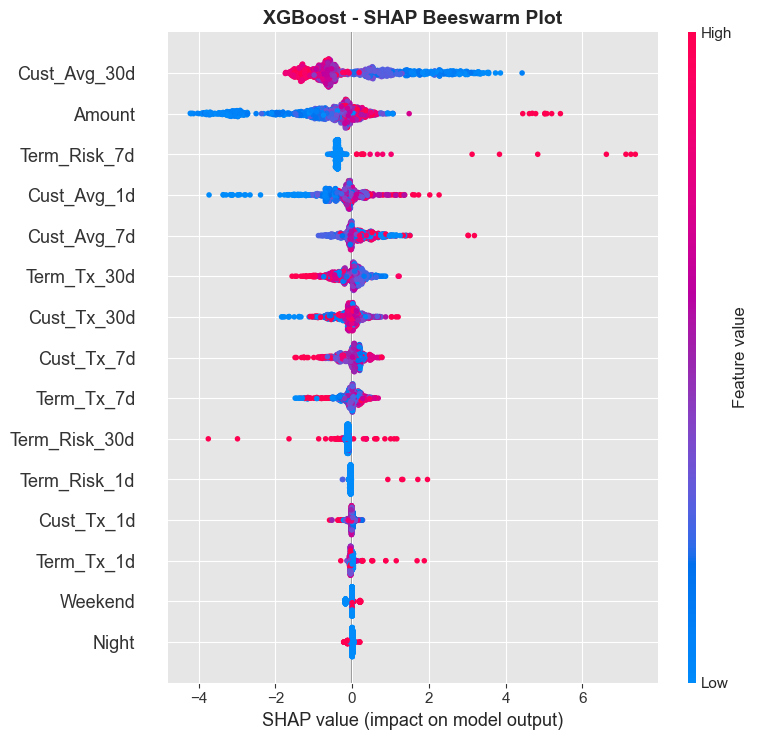

In [20]:
# XGBoost Beeswarm Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(shap_values_xgb, X_shap_sample, 
                  feature_names=short_feature_names,
                  show=False, max_display=15)
plt.title("XGBoost - SHAP Beeswarm Plot", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

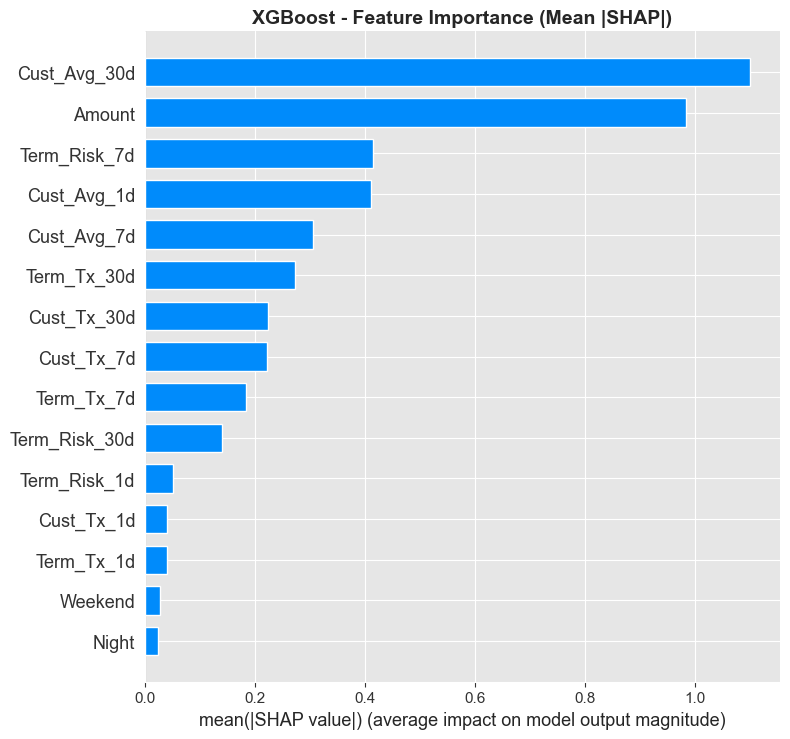

In [21]:
# XGBoost Feature Importance (Mean Absolute SHAP)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_shap_sample,
                  feature_names=short_feature_names,
                  plot_type="bar", show=False, max_display=15)
plt.title("XGBoost - Feature Importance (Mean |SHAP|)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### SHAP Analysis for Logistic Regression (Meta-Learner)

In [22]:
# For Logistic Regression, we'll analyze it as a base learner (not meta-learner)
# The meta-learner uses base model predictions as features, not original features
logreg_model = preformance_results_tuning['fitted_base_models']['LogisticRegression']

# Use LinearExplainer for Logistic Regression (efficient for linear models)
explainer_logreg = shap.LinearExplainer(logreg_model, X_shap_sample, feature_perturbation="interventional")
shap_values_logreg = explainer_logreg.shap_values(X_shap_sample)

print(f"LogisticRegression SHAP values shape: {shap_values_logreg.shape}")

LogisticRegression SHAP values shape: (1000, 15)


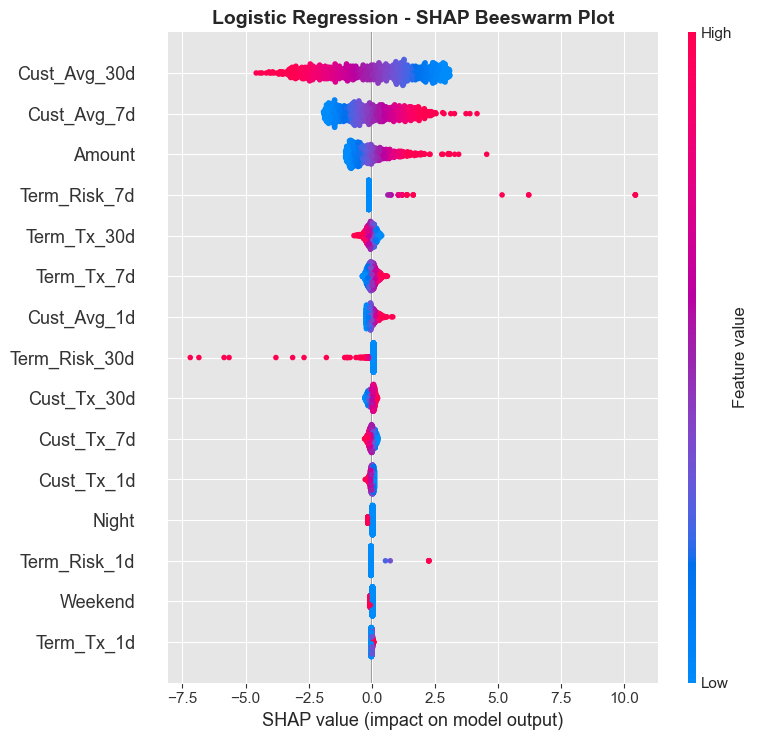

In [23]:
# Logistic Regression Beeswarm Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(shap_values_logreg, X_shap_sample,
                  feature_names=short_feature_names,
                  show=False, max_display=15)
plt.title("Logistic Regression - SHAP Beeswarm Plot", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

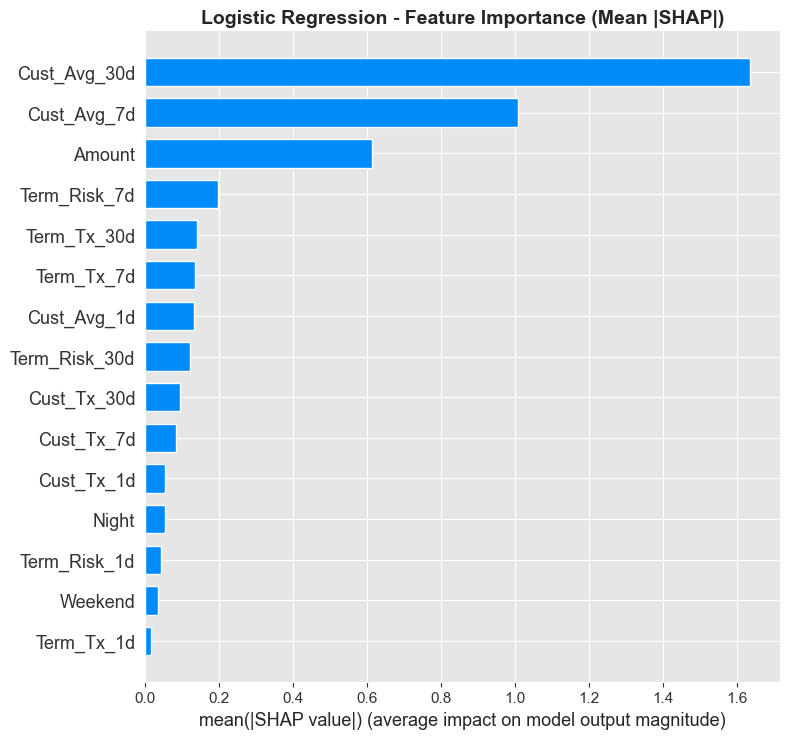

In [24]:
# Logistic Regression Feature Importance (Mean Absolute SHAP)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
shap.summary_plot(shap_values_logreg, X_shap_sample,
                  feature_names=short_feature_names,
                  plot_type="bar", show=False, max_display=15)
plt.title("Logistic Regression - Feature Importance (Mean |SHAP|)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### SHAP Analysis for Super Learner

In [28]:
# For Super Learner, we need to create a wrapper that combines base models + meta-learner
class SuperLearnerWrapper:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
    
    def predict(self, X):
        """Predict fraud probability (class 1) using the super learner pipeline"""
        # Generate base model predictions
        meta_features = []
        for model in self.base_models.values():
            pred = utils_training.get_predict_proba(model, X)
            meta_features.append(pred.reshape(-1, 1))
        X_meta = np.hstack(meta_features)
        
        # Meta-learner prediction - return probability of fraud (class 1)
        return self.meta_model.predict_proba(X_meta)[:, 1]

# Create super learner wrapper
super_learner = SuperLearnerWrapper(
    preformance_results_tuning['fitted_base_models'],
    preformance_results_tuning['meta_model']
)

# Use KernelExplainer for the super learner (model-agnostic approach)
# Sample background data for KernelExplainer (50 samples for efficiency)
background_sample = shap.sample(X_shap_sample, min(50, len(X_shap_sample)))
explainer_sl = shap.KernelExplainer(super_learner.predict, background_sample)

# Compute SHAP values (use smaller sample for efficiency due to KernelExplainer cost)
shap_sample_sl = X_shap_sample[:min(100, len(X_shap_sample))]
shap_values_sl = explainer_sl.shap_values(shap_sample_sl)

print(f"SuperLearner SHAP values shape: {shap_values_sl.shape}")
print(f"SuperLearner SHAP values type: {type(shap_values_sl)}")

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]

SuperLearner SHAP values shape: (100, 15)
SuperLearner SHAP values type: <class 'numpy.ndarray'>


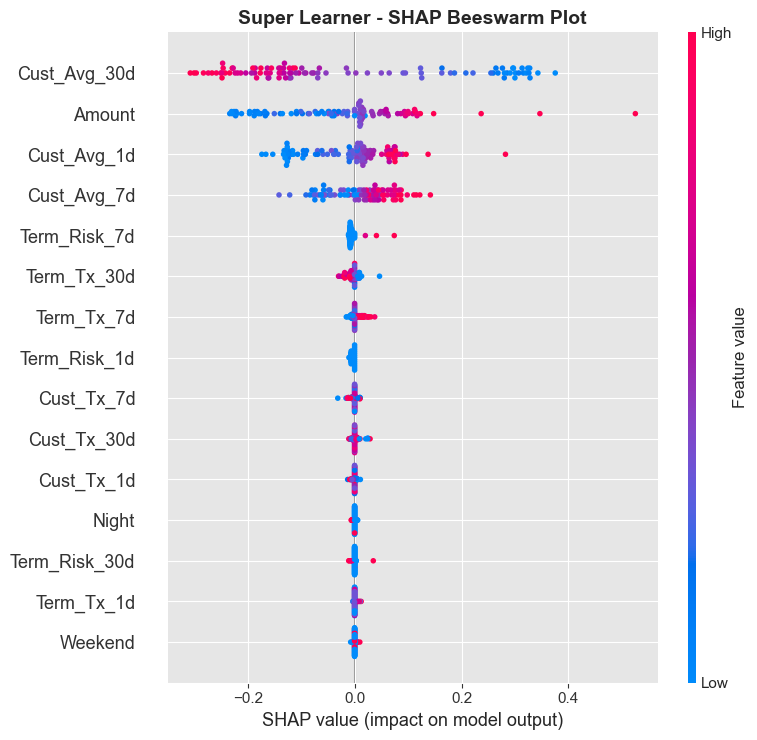

In [29]:
# Super Learner Beeswarm Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(shap_values_sl, shap_sample_sl,
                  feature_names=short_feature_names,
                  show=False, max_display=15)
plt.title("Super Learner - SHAP Beeswarm Plot", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

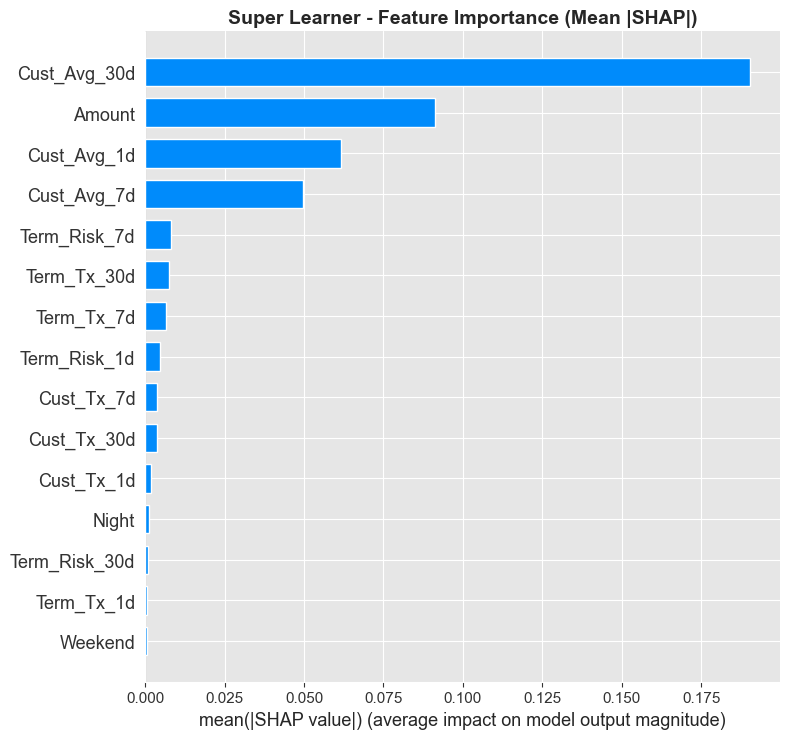

In [30]:
# Super Learner Feature Importance (Mean Absolute SHAP)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
shap.summary_plot(shap_values_sl, shap_sample_sl,
                  feature_names=short_feature_names,
                  plot_type="bar", show=False, max_display=15)
plt.title("Super Learner - Feature Importance (Mean |SHAP|)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## AUROC Comparison: Super Learner vs Base Learners

In [31]:
from sklearn.metrics import roc_curve, auc

# Use the same test set for fair comparison
X_test_roc = X_test_scaled_shap
y_test_roc = y_test_shap.values

# Get predictions from all base models
base_models_dict = preformance_results_tuning['fitted_base_models']
meta_model_roc = preformance_results_tuning['meta_model']

# Store predictions for each model
predictions = {}

# Base learner predictions
for model_name, model in base_models_dict.items():
    y_pred_proba = utils_training.get_predict_proba(model, X_test_roc)
    predictions[model_name] = y_pred_proba

# Super Learner predictions
# Generate meta-features from base models
meta_features_roc = []
for model in base_models_dict.values():
    pred = utils_training.get_predict_proba(model, X_test_roc)
    meta_features_roc.append(pred.reshape(-1, 1))
X_meta_roc = np.hstack(meta_features_roc)
predictions['Super Learner'] = meta_model_roc.predict_proba(X_meta_roc)[:, 1]

print(f"Generated predictions for {len(predictions)} models")
print(f"Test set size: {len(y_test_roc)}, Fraud rate: {y_test_roc.mean():.4f}")

Generated predictions for 8 models
Test set size: 57931, Fraud rate: 0.0061


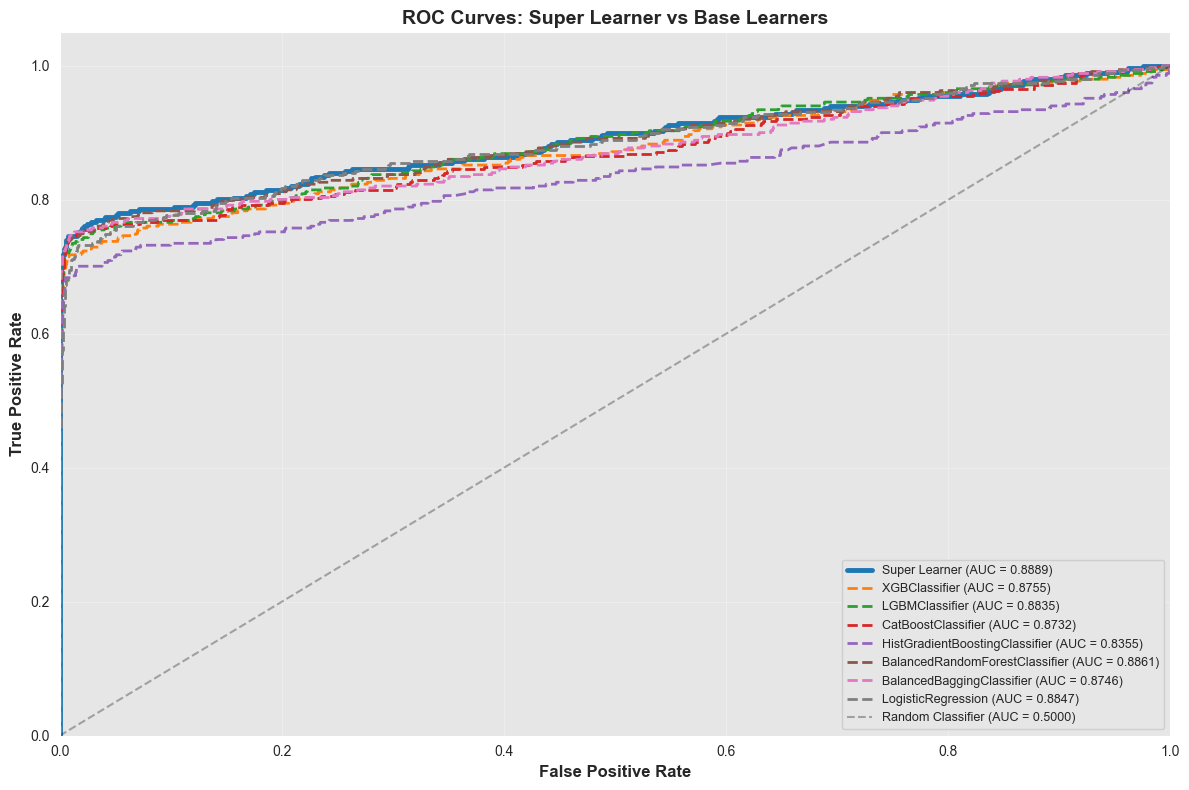

In [32]:
# Calculate ROC curves and AUC for all models
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Define color palette and line styles
colors = plt.cm.tab10(np.linspace(0, 1, 10))
model_order = ['Super Learner', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier',
               'HistGradientBoostingClassifier', 'BalancedRandomForestClassifier',
               'BalancedBaggingClassifier', 'LogisticRegression']

# Plot ROC curve for each model
for idx, model_name in enumerate(model_order):
    if model_name in predictions:
        y_pred = predictions[model_name]
        fpr, tpr, _ = roc_curve(y_test_roc, y_pred)
        roc_auc = auc(fpr, tpr)
        
        # Emphasize Super Learner with thicker line
        linewidth = 3.5 if model_name == 'Super Learner' else 2.0
        linestyle = '-' if model_name == 'Super Learner' else '--'
        
        ax.plot(fpr, tpr, color=colors[idx], lw=linewidth, linestyle=linestyle,
                label=f'{model_name} (AUC = {roc_auc:.4f})')

# Plot diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3, label='Random Classifier (AUC = 0.5000)')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: Super Learner vs Base Learners', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Advanced Performance Analysis

### 1. Precision-Recall Curves (Critical for Imbalanced Data)

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate Precision-Recall curves for all models
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

colors = plt.cm.tab10(np.linspace(0, 1, 10))
model_order = ['Super Learner', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier',
               'HistGradientBoostingClassifier', 'BalancedRandomForestClassifier',
               'BalancedBaggingClassifier', 'LogisticRegression']

# Plot PR curve for each model
for idx, model_name in enumerate(model_order):
    if model_name in predictions:
        y_pred = predictions[model_name]
        precision, recall, _ = precision_recall_curve(y_test_roc, y_pred)
        ap_score = average_precision_score(y_test_roc, y_pred)
        
        # Emphasize Super Learner with thicker line
        linewidth = 3.5 if model_name == 'Super Learner' else 2.0
        linestyle = '-' if model_name == 'Super Learner' else '--'
        
        ax.plot(recall, precision, color=colors[idx], lw=linewidth, linestyle=linestyle,
                label=f'{model_name} (AP = {ap_score:.4f})')

# Baseline: fraud rate
fraud_rate = y_test_roc.mean()
ax.axhline(y=fraud_rate, color='k', linestyle='--', lw=1.5, alpha=0.3, 
           label=f'Baseline (Fraud Rate = {fraud_rate:.4f})')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves: Super Learner vs Base Learners', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNote: PR curves are more informative than ROC for imbalanced datasets.")
print(f"Fraud rate: {fraud_rate:.4f} ({int(y_test_roc.sum())}/{len(y_test_roc)} transactions)")

### 2. Threshold Analysis: Precision, Recall, F1-Score Trade-offs

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Threshold analysis for Super Learner
y_pred_sl = predictions['Super Learner']
thresholds = np.linspace(0.01, 0.99, 100)

precisions = []
recalls = []
f1_scores = []
fraud_detected_counts = []

for thresh in thresholds:
    y_pred_binary = (y_pred_sl >= thresh).astype(int)
    
    # Handle edge cases where all predictions are 0 or 1
    if y_pred_binary.sum() == 0:  # No positive predictions
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)
    else:
        precisions.append(precision_score(y_test_roc, y_pred_binary, zero_division=0))
        recalls.append(recall_score(y_test_roc, y_pred_binary, zero_division=0))
        f1_scores.append(f1_score(y_test_roc, y_pred_binary, zero_division=0))
    
    fraud_detected_counts.append(y_pred_binary.sum())

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Precision, Recall, F1-Score vs Threshold
ax1.plot(thresholds, precisions, 'b-', lw=2.5, label='Precision', alpha=0.8)
ax1.plot(thresholds, recalls, 'g-', lw=2.5, label='Recall', alpha=0.8)
ax1.plot(thresholds, f1_scores, 'r-', lw=2.5, label='F1-Score', alpha=0.8)

# Find optimal F1 threshold
optimal_idx = np.argmax(f1_scores)
optimal_thresh = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

ax1.axvline(x=optimal_thresh, color='purple', linestyle='--', lw=2, alpha=0.6,
            label=f'Optimal Threshold = {optimal_thresh:.3f}\n(F1 = {optimal_f1:.4f})')
ax1.scatter([optimal_thresh], [optimal_f1], color='red', s=100, zorder=5)

ax1.set_xlabel('Decision Threshold', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Super Learner: Threshold Analysis', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.05])

# Plot 2: Number of Flagged Transactions vs Threshold
ax2.plot(thresholds, fraud_detected_counts, 'orange', lw=2.5, alpha=0.8)
ax2.axhline(y=y_test_roc.sum(), color='red', linestyle='--', lw=2, alpha=0.6,
            label=f'Actual Frauds = {int(y_test_roc.sum())}')
ax2.axvline(x=optimal_thresh, color='purple', linestyle='--', lw=2, alpha=0.6,
            label=f'Optimal Threshold = {optimal_thresh:.3f}')

ax2.set_xlabel('Decision Threshold', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Flagged Transactions', fontsize=12, fontweight='bold')
ax2.set_title('Flagged Transactions vs Threshold', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Print optimal threshold details
print(f"\n{'='*60}")
print(f"OPTIMAL THRESHOLD ANALYSIS (Super Learner)")
print(f"{'='*60}")
print(f"Optimal Threshold: {optimal_thresh:.4f}")
print(f"  - Precision:     {precisions[optimal_idx]:.4f}")
print(f"  - Recall:        {recalls[optimal_idx]:.4f}")
print(f"  - F1-Score:      {optimal_f1:.4f}")
print(f"  - Flagged Txns:  {fraud_detected_counts[optimal_idx]:,}")
print(f"  - Actual Frauds: {int(y_test_roc.sum()):,}")
print(f"{'='*60}")

### 3. Calibration Plot: Predicted Probability vs Actual Fraud Rate

In [ ]:
from sklearn.calibration import calibration_curve

# Calibration analysis for top models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Models to analyze
calibration_models = ['Super Learner', 'XGBClassifier', 'LogisticRegression']
colors_calib = ['purple', 'blue', 'green']

# Plot 1: Calibration Curves
ax1 = axes[0]
for model_name, color in zip(calibration_models, colors_calib):
    if model_name in predictions:
        y_pred = predictions[model_name]
        
        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_test_roc, y_pred, n_bins=10, strategy='uniform')
        
        linewidth = 3.5 if model_name == 'Super Learner' else 2.0
        ax1.plot(prob_pred, prob_true, marker='o', lw=linewidth, color=color,
                label=f'{model_name}', markersize=8)

# Perfect calibration line
ax1.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Perfect Calibration')

ax1.set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual Fraud Rate', fontsize=12, fontweight='bold')
ax1.set_title('Calibration Plot: Reliability Diagram', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Plot 2: Prediction Distribution (Fraud vs Legitimate)
ax2 = axes[1]
y_pred_sl = predictions['Super Learner']

# Separate predictions by actual class
fraud_probs = y_pred_sl[y_test_roc == 1]
legit_probs = y_pred_sl[y_test_roc == 0]

# Plot histograms
ax2.hist(legit_probs, bins=50, alpha=0.6, color='blue', label=f'Legitimate (n={len(legit_probs):,})', density=True)
ax2.hist(fraud_probs, bins=50, alpha=0.6, color='red', label=f'Fraud (n={len(fraud_probs):,})', density=True)

# Add vertical line at optimal threshold
ax2.axvline(x=optimal_thresh, color='purple', linestyle='--', lw=2.5, alpha=0.8,
            label=f'Optimal Threshold = {optimal_thresh:.3f}')

ax2.set_xlabel('Predicted Fraud Probability', fontsize=12, fontweight='bold')
ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
ax2.set_title('Super Learner: Prediction Distribution', fontsize=14, fontweight='bold')
ax2.legend(loc='upper center', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Calculate calibration metrics
print(f"\n{'='*60}")
print(f"CALIBRATION ANALYSIS")
print(f"{'='*60}")

for model_name in calibration_models:
    if model_name in predictions:
        y_pred = predictions[model_name]
        prob_true, prob_pred = calibration_curve(y_test_roc, y_pred, n_bins=10, strategy='uniform')
        
        # Calculate calibration error (mean absolute difference)
        calib_error = np.mean(np.abs(prob_true - prob_pred))
        
        print(f"\n{model_name}:")
        print(f"  - Mean Calibration Error: {calib_error:.4f}")
        print(f"  - Mean Predicted Prob:     {y_pred.mean():.4f}")
        print(f"  - Actual Fraud Rate:       {y_test_roc.mean():.4f}")

print(f"\n{'='*60}")
print(f"Note: Lower calibration error indicates better probability estimates.")
print(f"Well-calibrated models have predicted probabilities that match actual frequencies.")
print(f"{'='*60}")